<a href="https://colab.research.google.com/github/lf2foce/taichinh/blob/master/iterrows_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from pypfopt import EfficientFrontier
#from pypfopt import risk_models
#from pypfopt import expected_returns
pd.set_option('display.max_columns', None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(14, 7))
#import csv & table ---------------------------------
data_index = pd.read_csv('/content/drive/My Drive/data_pricevolume06112019.csv')\
      [['Ticker', 'Date', 'High', 'Low', 'Open', 'Close', 'AdjRatio', 'TotalValue', 'Shares', 'Volume']]
fav_stocks = ['VCB', 'HPG', 'MWG', 'FPT', 'VNM']
vn30 = pd.read_csv('/content/drive/My Drive/data_analyst/VN30.csv')
vn30 = vn30['Ticker'].values
selected_ratios = pd.read_excel('/content/drive/My Drive/data_analyst/selected_ratios.xlsx')
sector_L2 = pd.read_csv('/content/drive/My Drive/data_analyst/sectorl2.csv')
#filter & format
data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index = data_index[ (data_index.Ticker.isin(fav_stocks)) &  (data_index['Date'] >= '2015-01-01') ]  #  ((data_index.Ticker.isin(fav_stocks)) & 
#add column
data_index['Year'] = data_index['Date'].apply(lambda x: x.year)
data_index['Adj_Close'] = data_index['Close'] / data_index['AdjRatio']

data_index = data_index.set_index('Date')
print(data_index.head())


           Ticker      High       Low      Open     Close  AdjRatio  \
Date                                                                  
2015-01-05    FPT   48200.0   47600.0   48000.0   47800.0  2.386305   
2015-01-05    HPG   54000.0   52500.0   53000.0   53000.0  5.310182   
2015-01-05    MWG  110000.0  107000.0  110000.0  108000.0  3.535226   
2015-01-05    VCB   32100.0   31400.0   31700.0   31900.0  1.469269   
2015-01-05    VNM   96500.0   95500.0   96000.0   96000.0  2.092808   

              TotalValue        Shares  Volume  Year     Adj_Close  
Date                                                                
2015-01-05  3.490742e+10  3.438942e+08  705788  2015  20030.968404  
2015-01-05  1.097206e+10  4.819082e+08  207020  2015   9980.824948  
2015-01-05  1.952649e+09  1.119535e+08   18030  2015  30549.676677  
2015-01-05  9.889319e+09  2.665020e+09  310010  2015  21711.473219  
2015-01-05  1.902215e+10  1.000119e+09  194733  2015  45871.378172  
CPU times: user 5.8

<Figure size 1008x504 with 0 Axes>

In [0]:
class TickData(object):
	""" Stores a single unit of data """

	def __init__(self, timestamp='', symbol='',
				open_price=0, close_price=0, total_volume=0):
		self.symbol = symbol
		self.timestamp = timestamp
		self.open_price = open_price
		self.close_price = close_price
		self.total_volume = total_volume

In [0]:
class MarketData(object):
	def __init__(self):
		self.recent_ticks = dict()  # indexed by symbol

	def add_tick_data(self, tick_data):
		self.recent_ticks[tick_data.symbol] = tick_data

	def get_open_price(self, symbol):
		return self.get_tick_data(symbol).open_price

	def get_close_price(self, symbol):
		return self.get_tick_data(symbol).close_price

	def get_tick_data(self, symbol):
		return self.recent_ticks.get(symbol, TickData())

	def get_timestamp(self, symbol):
		return self.recent_ticks[symbol].timestamp

In [0]:
#dang tu lam
pd.set_option('display.max_columns', None)
#symbol = 'WIKI/AAPL'
symbol = ['VCB']
start='2017-01-01'
end='2017-12-31'

def fetch_historical_prices(symbol, start_date, end_date):
    #df = data_index[(data_index['Ticker'].isin(symbol)) & (data_index['Date'] > start_date) & (data_index['Date'] < end_date) ]
    df = data_index[(data_index['Ticker'].isin(symbol))] 
    #df = data_index[(data_index['Ticker'] == self.symbol] 
    df = df.loc[start_date: end_date]
    return df
print(fetch_historical_prices(symbol, start, end))

#ben duoi chuan het, test thử 

In [0]:
#symbol = ['VCB']
#start='2017-01-01'
#end='2017-12-31'

class MarketDataSource(object):
    def __init__(self, symbol, tick_event_handler=None, start='', end=''):
        self.market_data = MarketData()

        self.symbol = symbol
        self.tick_event_handler = tick_event_handler
        self.start, self.end = start, end
        self.df = None

    def fetch_historical_prices(self):
        #df = data_index[(data_index['Ticker'].isin(self.symbol))] 
        df = data_index[ data_index['Ticker'] == self.symbol ]
        df = df.loc[self.start: self.end]
        return df


    def run(self):
        if self.df is None:
            self.df = self.fetch_historical_prices()

        total_ticks = len(self.df)
        print('Processing total_ticks:', total_ticks)

        for timestamp, row in self.df.iterrows():
            open_price = row['Open']
            close_price = row['Close']
            volume = row['Volume']

            print(timestamp.date(), 'TICK', self.symbol,
                  'open:', open_price,
                  'close:', close_price)
            tick_data = TickData(timestamp, self.symbol, open_price,
                                close_price, volume)
            self.market_data.add_tick_data(tick_data)

            if self.tick_event_handler:
                self.tick_event_handler(self.market_data)
#audi = MarketDataSource(symbol, start='2016-01-01', end='2017-12-31')
#audi.fetch_historical_prices()

In [0]:
class Order(object):
	def __init__(self, timestamp, symbol, 
		qty, is_buy, is_market_order, 
		price=0
	):
		self.timestamp = timestamp
		self.symbol = symbol
		self.qty = qty
		self.price = price
		self.is_buy = is_buy
		self.is_market_order = is_market_order
		self.is_filled = False
		self.filled_price = 0
		self.filled_time = None
		self.filled_qty = 0

In [0]:
class Position(object):
	def __init__(self, symbol=''):
		self.symbol = symbol
		self.buys = self.sells = self.net = 0
		self.rpnl = 0 #recently realized profits and losses
		self.position_value = 0  #securities is credit into this acct

	def on_position_event(self, is_buy, qty, price):
		if is_buy:
			self.buys += qty
		else:
			self.sells += qty

		self.net = self.buys - self.sells
		changed_value = qty * price * (-1 if is_buy else 1)
		self.position_value += changed_value

		if self.net == 0:
			self.rpnl = self.position_value
			self.position_value = 0

	def calculate_unrealized_pnl(self, price):
		if self.net == 0:
			return 0

		market_value = self.net * price
		upnl = self.position_value + market_value
		return upnl

In [0]:
from abc import abstractmethod

class Strategy:
	def __init__(self, send_order_event_handler):
		self.send_order_event_handler = send_order_event_handler

	@abstractmethod
	def on_tick_event(self, market_data):
		raise NotImplementedError('Method is required!')

	@abstractmethod
	def on_position_event(self, positions):
		raise NotImplementedError('Method is required!')

	def send_market_order(self, symbol, qty, is_buy, timestamp):
		if self.send_order_event_handler:
			order = Order(
				timestamp,
				symbol,
				qty,
				is_buy,
				is_market_order=True,
				price=0,
			)
			self.send_order_event_handler(order)

In [0]:
import pandas as pd

class MeanRevertingStrategy(Strategy):
    def __init__(self, symbol, trade_qty,
        send_order_event_handler=None, lookback_intervals=20,
        buy_threshold=-1.5, sell_threshold=1.5
    ):
        super(MeanRevertingStrategy, self).__init__(
            send_order_event_handler)

        self.symbol = symbol
        self.trade_qty = trade_qty
        self.lookback_intervals = lookback_intervals
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

        self.prices = pd.DataFrame()
        self.is_long = self.is_short = False

    def on_position_event(self, positions):
        position = positions.get(self.symbol)

        self.is_long = position and position.net > 0
        self.is_short = position and position.net < 0

    def on_tick_event(self, market_data):
        self.store_prices(market_data)

        if len(self.prices) < self.lookback_intervals:
            return

        self.generate_signals_and_send_order(market_data)

    def store_prices(self, market_data):
        timestamp = market_data.get_timestamp(self.symbol)
        close_price = market_data.get_close_price(self.symbol)
        self.prices.loc[timestamp, 'close'] = close_price

    def generate_signals_and_send_order(self, market_data):
        signal_value = self.calculate_z_score()
        timestamp = market_data.get_timestamp(self.symbol)

        if self.buy_threshold > signal_value and not self.is_long:
            print(timestamp.date(), 'BUY signal')
            self.send_market_order(
                self.symbol, self.trade_qty, True, timestamp)
        elif self.sell_threshold < signal_value and not self.is_short:
            print(timestamp.date(), 'SELL signal')
            self.send_market_order(
                self.symbol, self.trade_qty, False, timestamp)

    def calculate_z_score(self):
        self.prices = self.prices[-self.lookback_intervals:]
        returns = self.prices['close'].pct_change().dropna()
        z_score = ((returns - returns.mean()) / returns.std())[-1]
        return z_score

In [0]:
class BacktestEngine:
	def __init__(self, symbol, trade_qty, start='', end=''):
		self.symbol = symbol
		self.trade_qty = trade_qty
		self.market_data_source = MarketDataSource(
			symbol,
			tick_event_handler=self.on_tick_event,
			start=start, end=end
		)

		self.strategy = None
		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = None
        
	def start(self, **kwargs):
		print('Backtest started...')

		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = pd.DataFrame()

		self.strategy = MeanRevertingStrategy(
			self.symbol,
			self.trade_qty,
			send_order_event_handler=self.on_order_received,
			**kwargs
		)
		self.market_data_source.run()

		print('Backtest completed.')
        
	def on_order_received(self, order):
		""" Adds an order to the order book """
		print(
			order.timestamp.date(),
			'ORDER',
			'BUY' if order.is_buy else 'SELL',
			order.symbol,
			order.qty
		)
		self.unfilled_orders.append(order)
        
	def on_tick_event(self, market_data):
		self.match_order_book(market_data)
		self.strategy.on_tick_event(market_data)
		self.print_position_status(market_data)
        
	def match_order_book(self, market_data):
		if len(self.unfilled_orders) > 0:
			self.unfilled_orders = [
				order for order in self.unfilled_orders
				if self.match_unfilled_orders(order, market_data)
			]
            
	def match_unfilled_orders(self, order, market_data):
		symbol = order.symbol
		timestamp = market_data.get_timestamp(symbol)

		""" Order is matched and filled """
		if order.is_market_order and timestamp > order.timestamp:
			open_price = market_data.get_open_price(symbol)

			order.is_filled = True
			order.filled_timestamp = timestamp
			order.filled_price = open_price

			self.on_order_filled(
				symbol, order.qty, order.is_buy,
				open_price, timestamp
			)
			return False

		return True
    
	def on_order_filled(self, symbol, qty, is_buy, filled_price, timestamp):
		position = self.get_position(symbol)
		position.on_position_event(is_buy, qty, filled_price)
		self.df_rpnl.loc[timestamp, "rpnl"] = position.rpnl

		self.strategy.on_position_event(self.positions)

		print(
			timestamp.date(),
			'FILLED', "BUY" if is_buy else "SELL",
			qty, symbol, 'at', filled_price
		)
        
	def get_position(self, symbol):
		if symbol not in self.positions:
			self.positions[symbol] = Position(symbol)

		return self.positions[symbol]
    
	def print_position_status(self, market_data):
		for symbol, position in self.positions.items():
			close_price = market_data.get_close_price(symbol)
			timestamp = market_data.get_timestamp(symbol)

			upnl = position.calculate_unrealized_pnl(close_price)

			print(
				timestamp.date(),
				'POSITION',
				'value:%.3f' % position.position_value,
				'upnl:%.3f' % upnl,
				'rpnl:%.3f' % position.rpnl
			)

In [0]:
engine = BacktestEngine(
    'VCB', 1000,
    start='2015-01-01',
    end='2017-12-31'
)

In [36]:
engine.start(
    lookback_intervals=20,
    buy_threshold=-1.5,
    sell_threshold=1.5
)

Backtest started...
Processing total_ticks: 749
2015-01-05 TICK VCB open: 31700.0 close: 31900.0
2015-01-06 TICK VCB open: 31900.0 close: 34000.0
2015-01-07 TICK VCB open: 34100.0 close: 33600.0
2015-01-08 TICK VCB open: 33700.0 close: 34600.0
2015-01-09 TICK VCB open: 34900.0 close: 36900.0
2015-01-12 TICK VCB open: 37000.0 close: 37200.0
2015-01-13 TICK VCB open: 37000.0 close: 37000.0
2015-01-14 TICK VCB open: 36800.0 close: 37400.0
2015-01-15 TICK VCB open: 37200.0 close: 36800.0
2015-01-16 TICK VCB open: 36800.0 close: 36300.0
2015-01-19 TICK VCB open: 36400.0 close: 35400.0
2015-01-20 TICK VCB open: 35400.0 close: 36000.0
2015-01-21 TICK VCB open: 36000.0 close: 35400.0
2015-01-22 TICK VCB open: 35400.0 close: 36200.0
2015-01-23 TICK VCB open: 36500.0 close: 37100.0
2015-01-26 TICK VCB open: 37100.0 close: 36600.0
2015-01-27 TICK VCB open: 36500.0 close: 36300.0
2015-01-28 TICK VCB open: 36300.0 close: 37400.0
2015-01-29 TICK VCB open: 37400.0 close: 36900.0
2015-01-30 TICK VCB o

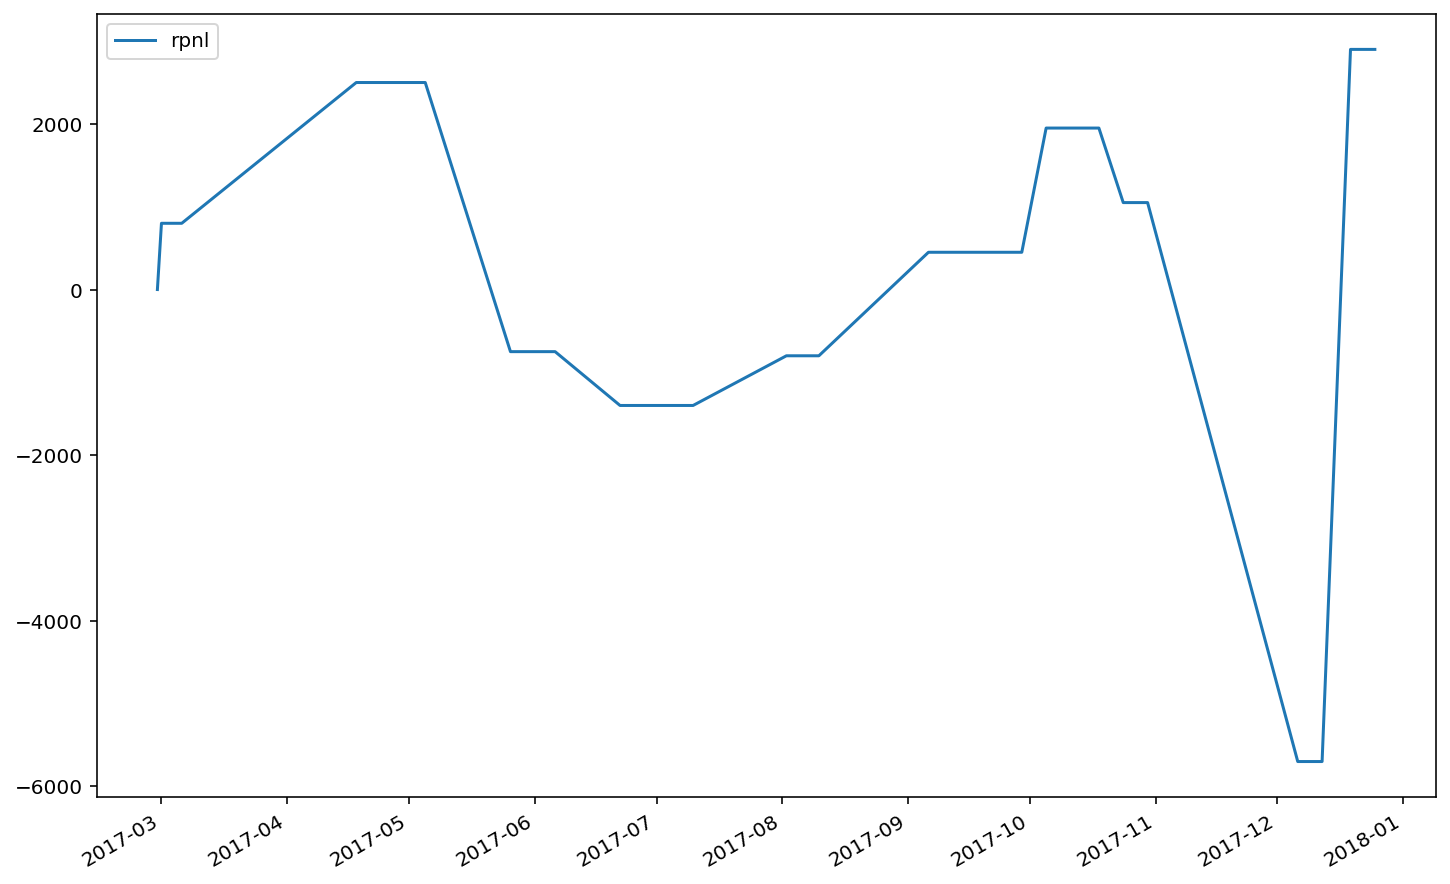

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

engine.df_rpnl.plot(figsize=(12, 8));

In [0]:

def fetch_historical_prices(symbol, start, end):
    import quandl

    # Update your Quandl API key here...
    QUANDL_API_KEY = 'vfB6Ln8TQsxweRFnn89J'
    quandl.ApiConfig.api_key = QUANDL_API_KEY
    df = quandl.get(symbol, start_date=start, end_date=end)
    return df
fetch_historical_prices('WIKI/AAPL', start='2015-01-01',
    end='2017-12-31')    